<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/notebooks/augment_segmented_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install imgaug
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.1/800.1 kB 8.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
from imgaug import augmenters as iaa
from PIL import Image
from pathlib import Path
from ultralytics import YOLO
import imgaug as ia
import imageio
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5

In [5]:
def augment_png(source_png_folder_path, augmented_png_folder_path, number_of_augs_plus_originals):
  """
  Reads a folder of PNG images, applies augmentations, and saves as PNG files.

  Args:
      source_png_folder__path: Path to the input folder of PNG images.
      augmented_png_folder_path: Path to the output folder of augmented PNG images, plus the originals
      number_of_augs_plus_originals: Total number of images (augmented plus originals) to end up with.  Because we
      do integer division, we won't always end up with exactly number_of_augs_plus_originals images.  But this will
      be close enough to give us a balanced training set.
  """

  # Read all the PNG files in the source folder
  png_files = glob.glob(os.path.join(source_png_folder_path, '*.png'))
  png_images = [cv2.imread(png_path, cv2.IMREAD_COLOR) for png_path in png_files]


  # Calculate number of augmentations to make of each image.  Since we're doing
  # integer division, we won't always end up with exactly number_of_augs_plus_originals
  # images (augmented plus originals).  But this will be close enough to give us
  # a balanced training set.
  number_of_augs = number_of_augs_plus_originals - len(png_images)
  number_of_augs_per_original = number_of_augs // len(png_images)
  if number_of_augs_per_original == 0:
    number_of_augs_per_original = 1


  # Define augmentation sequence
  augment_seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Add salt and pepper noise
    iaa.SaltAndPepper(0.05),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
  ], random_order=True) # apply augmenters in random order

  # Load YOLOv8 model for instance segmentation.  We need this because the augmented images will be produced with
  # black, rather than transparent, backgrounds.  (There doesn't seem to be a way to tell imgaug to produce transparent
  # backgrounds.). So we need to isolate the augmented cat image to put it on a transparent background.
  trained_model = YOLO('/content/gdrive/MyDrive/Cat images/models/feral-cat-segmentation.v1i.yolov8/200-epochs-/weights/best.pt') #(4)!

  # Loop to augment each original N times and write it out.
  for idx, filepath in enumerate(png_files):
    # Augment the next original image N times, where N = number_of_augs_per_original
    augmented_images = augment_seq(images=[png_images[idx] for i in range(number_of_augs_per_original)])

    # This code extracts each object from an image using its segmentation mask predicted by the YOLO v8 feral cat segmentation model.
    # This code was adapted (slightly) from the code in the YOLO v8 documentation, which can be found at
    # https://docs.ultralytics.com/guides/isolating-segmentation-objects/#recipe-walk-through.  The numbers in parentheses refer to steps
    # and explanations in that documentation.

    res = trained_model.predict(augmented_images, conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD) #(3)!

    # iterate detection results (5)
    for r_index, r in enumerate(res):
      img = np.copy(r.orig_img)
      img_name = Path(filepath).stem

      # iterate each object contour (6)
      for ci,c in enumerate(r):

        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask (1)
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        # Isolate object with transparent background (when saved as PNG)
        isolated = np.dstack([img, b_mask])

        # Detection crop
        x1, y1, x2, y2 = c.boxes.xyxy.cpu().numpy().squeeze().astype(np.int32)
        iso_crop = isolated[y1:y2, x1:x2]

        # Save isolated object to file
        _ = cv2.imwrite(f'{augmented_png_folder_path}/{img_name}_aug-{idx}-{r_index}.png', iso_crop)

  # Loop to copy the original PNG files to the augmented directory
  for png_path in png_files:
    img = Image.open(png_path)

    # Check if the image has transparency (alpha channel)
    if img.mode == 'RGBA':
      # Copy the image with the same mode (RGBA) to preserve transparency
      img_copy = img.copy()
    else:
      # Image doesn't have transparency, simply copy the data
      img_copy = img.convert('RGBA')  # Convert to RGBA for consistency

    # Save the copied image
    img_copy.save(png_path.replace(source_png_folder_path, augmented_png_folder_path))


In [6]:
segmented_zip_files_list = sorted(glob.glob('*_segmented.zip'))
print(segmented_zip_files_list)
categories_with_higher_limit = ['solid', 'tabby_classic', 'tortoiseshell']

['tuxedo_1_segmented.zip', 'tuxedo_2_segmented.zip']


In [7]:
for zip_file in segmented_zip_files_list:
  IMAGE_FILENAME_ROOT = zip_file.split('.')[0][:-len('_segmented')]
  !unzip '{IMAGE_FILENAME_ROOT}_segmented.zip'
  !mkdir {IMAGE_FILENAME_ROOT}_augmented
  source_png_folder_path = f'{IMAGE_FILENAME_ROOT}_segmented'
  augmented_png_folder_path = f'{IMAGE_FILENAME_ROOT}_augmented'
  if IMAGE_FILENAME_ROOT in categories_with_higher_limit:
    TOTAL_AUG_PLUS_ORIG = 500
  else:
    TOTAL_AUG_PLUS_ORIG = 300
  augment_png(source_png_folder_path,augmented_png_folder_path, TOTAL_AUG_PLUS_ORIG)
  !zip -r '{IMAGE_FILENAME_ROOT}_augmented.zip' '{IMAGE_FILENAME_ROOT}_augmented'
  !rm -rf {IMAGE_FILENAME_ROOT}_segmented
  !rm -rf {IMAGE_FILENAME_ROOT}_augmented
  !rm '{IMAGE_FILENAME_ROOT}_segmented.zip'

Archive:  tuxedo_1_segmented.zip
   creating: tuxedo_1_segmented/
  inflating: tuxedo_1_segmented/tux_gray_0007_cat-0.png  
  inflating: __MACOSX/tuxedo_1_segmented/._tux_gray_0007_cat-0.png  
  inflating: tuxedo_1_segmented/tux_gray_0013_cat-0.png  
  inflating: __MACOSX/tuxedo_1_segmented/._tux_gray_0013_cat-0.png  
  inflating: tuxedo_1_segmented/tux_black_0009_cat-0.png  
  inflating: __MACOSX/tuxedo_1_segmented/._tux_black_0009_cat-0.png  
  inflating: tuxedo_1_segmented/tux_blue_0009_cat-0.png  
  inflating: __MACOSX/tuxedo_1_segmented/._tux_blue_0009_cat-0.png  
  inflating: tuxedo_1_segmented/tux_black_0052_cat-0.png  
  inflating: __MACOSX/tuxedo_1_segmented/._tux_black_0052_cat-0.png  
  inflating: tuxedo_1_segmented/tux_black_0028_cat-0.png  
  inflating: __MACOSX/tuxedo_1_segmented/._tux_black_0028_cat-0.png  
  inflating: tuxedo_1_segmented/tux_0013_cat-0.png  
  inflating: __MACOSX/tuxedo_1_segmented/._tux_0013_cat-0.png  
  inflating: tuxedo_1_segmented/tux_0007_cat-0.pn

<ipython-input-20-46dec5471da5>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('composite_red_white_augmented/comp_red_white_0001_cat-0.png')


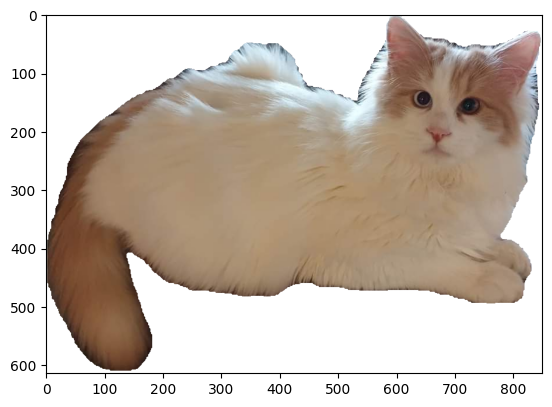

In [ ]:
image = imageio.imread('composite_red_white_augmented/comp_red_white_0001_cat-0.png')
plt.imshow(image)
plt.show;

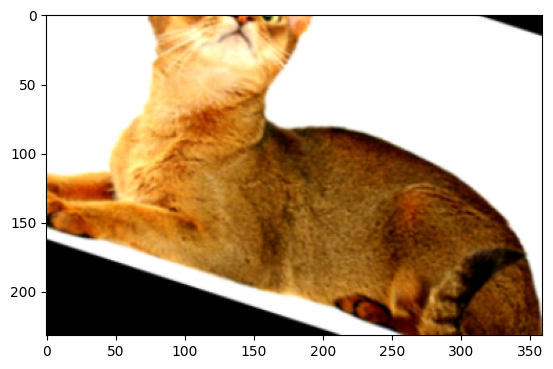

In [ ]:
plt.imshow(image)
plt.show;

<ipython-input-8-b69f37425869>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(copy_file)


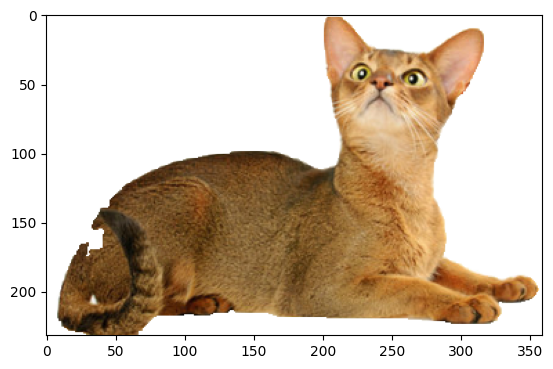

In [ ]:
image = imageio.imread(copy_file)
plt.imshow(image)
plt.show;

In [9]:
!cp -R tuxedo_2_augmented.zip 'gdrive/MyDrive/Cat images/Cat coat patterns/augmented_zip_files/'

In [ ]:
!rm -rf *.zip

In [12]:
!mkdir tuxedo_1